In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re 
from datetime import date, datetime
import numpy as np
import random
import copy
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



In [2]:
plt.style.use('seaborn')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)
plt.rcParams.update({'font.size': 16})


# Task 1: Explore a small dataset
### Task 1A: Exploration

In [3]:
df = pd.read_csv("data/ODI-2020.csv", sep=';')

# rename to normal column names for easier referencing later
df.columns=["program", "ml_course", "ir_course", "stat_course", "db_course", "gender",
                "chocolate", "birthday", "neighbors", "standed_up", "stress", "local_dm_comp", "random_number",
                "bedtime_yesterday", "happy1", "happy2"]
display(df)

,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,neighbors,standed_up,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2
0,Computational Science,no,unknown,mu,ja,female,fat,05-08-1998,0,no,0,4,227,22:30,Good weather,Sporting
1,Quantitative Risk Management,no,0,mu,nee,male,unknown,1996,2,no,85,25,65,23:05,chill,coffee
2,MSc Computational Science,no,0,mu,ja,female,neither,12th June,4,no,50,10,3,10pm,Waking up early and preparing for the day by p...,Using the early morning time to study
3,MSc Finance - QRM,no,0,mu,nee,female,neither,19-06-1994,0,no,10,99,2,23,eating good food,spending time with friends
4,BA,yes,0,mu,ja,male,neither,29-09-1993,0,no,60,80,7,22:00,Sun is shining,Intimate contact with friends and family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Mechenaical Engineering,yes,1,mu,nee,male,fat,17-09-1993,2,no,69,5,6,1:00,no corona,no corona 2
276,CS,no,0,mu,ja,male,fat,28/10,0,no,10,100,7,21:45,Netflix,Chill
277,Artificial Intelligence,yes,1,mu,ja,male,neither,26-07-1994,12,yes,60,75,42,13:37,Finishing all tasks,Finding an extra package of ice cream
278,Artificial Intelligence,no,0,mu,nee,female,neither,3/4/1998,1,no,70,2,69,00:00,Food,Orgasm


### Clean

In [4]:
# clean up open questions: master can be CLS/computational science/Computational Science/Master Computational Science, etc.
import string

df = pd.read_csv("data/ODI-2020.csv", sep=';')

# rename to normal column names for easier referencing later
df.columns=["program", "ml_course", "ir_course", "stat_course", "db_course", "gender",
                "chocolate", "birthday", "neighbors", "standed_up", "stress", "local_dm_comp", "random_number",
                "bedtime_yesterday", "happy1", "happy2"]
# display(df)


#print("Unique progams:", len(df.program.unique()))
#print("Changing everything to lowercase")
df.program = df.program.map(str.lower)

#print("Unique progams:", len(df.program.unique()))
#print("Deleting all punctuation")
# text = text.translate()

df.program = df.program.map(lambda s: s.translate(str.maketrans('','', string.punctuation)))
#print("Unique progams:", len(df.program.unique()))


#print("\n\n\n")

# # oude onderverdeling
# for index, row in df.iterrows():
#     if "computational" in row.program or "cls" in row.program:
#         row.program = "CLS"
#     elif "artificial" in row.program or "ai" in row.program:
#         row.program = "AI"
#     elif "computer science" in row.program or "cs" in row.program:
#         row.program = "CS"
#     elif "quantitative risk management" in row.program or "qrm" in row.program:
#         row.program = "QRM"

# nieuwe onderverdeling
for index, row in df.iterrows():
    if "computational" in row.program or "cls" in row.program or "computing" in row.program or "information" in row.program:
        row.program = "CLS"
    elif "artificial" in row.program or "ai" in row.program:
        row.program = "AI"
    elif "computer science" in row.program or "cs" in row.program or "parallel" in row.program or "data" in row.program:
        row.program = "CS"
    # finance studies
    elif "quantitative risk management" in row.program or "qrm" in row.program or "finance" in row.program or "business" in row.program:
        row.program = "QRM"
    else:
        row.program = "OTHER"
print("Unique progams:", len(df.program.unique()))
print(df.program.unique())

Unique progams: 5
['CLS' 'QRM' 'OTHER' 'CS' 'AI']


In [5]:
display(df)

,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,neighbors,standed_up,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2
0,CLS,no,unknown,mu,ja,female,fat,05-08-1998,0,no,0,4,227,22:30,Good weather,Sporting
1,QRM,no,0,mu,nee,male,unknown,1996,2,no,85,25,65,23:05,chill,coffee
2,CLS,no,0,mu,ja,female,neither,12th June,4,no,50,10,3,10pm,Waking up early and preparing for the day by p...,Using the early morning time to study
3,QRM,no,0,mu,nee,female,neither,19-06-1994,0,no,10,99,2,23,eating good food,spending time with friends
4,OTHER,yes,0,mu,ja,male,neither,29-09-1993,0,no,60,80,7,22:00,Sun is shining,Intimate contact with friends and family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,AI,yes,1,mu,nee,male,fat,17-09-1993,2,no,69,5,6,1:00,no corona,no corona 2
276,CS,no,0,mu,ja,male,fat,28/10,0,no,10,100,7,21:45,Netflix,Chill
277,AI,yes,1,mu,ja,male,neither,26-07-1994,12,yes,60,75,42,13:37,Finishing all tasks,Finding an extra package of ice cream
278,AI,no,0,mu,nee,female,neither,3/4/1998,1,no,70,2,69,00:00,Food,Orgasm


In [6]:
# Clean birthday
df_new = df.copy()
df_new["age"] = np.nan

def calculateAge(birthDate): 
    today = date.today() 
    return today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 

for index,row in df_new.iterrows():
    line = re.split("-|/|th|of|''|' ' ", row["birthday"])
    if len(line) == 1:
        line = line[0].split(".")

    if len(line) == 1:
        if line[0].startswith('199') or line[0].startswith('198'):
            year = int(line[0])

            if year > 1900 and year < 2010:
                date_str = date(year, 1, 1)
                age = calculateAge(date_str)
    
    elif len(line) == 3 and ' ' not in line:
        for i in range(len(line)): 
            if line[i] == "march ": 
                line[i] = 3
        line = [int(i) for i in line] 
        year, month, day = line[2], line[1], line[0]
        
        # For entries of '94' in stead of '1994'
        if year > 60 and year < 1900:
            year = int('19' + str(year))
            
         # Calculate date with year - month - day
        try:
            date_str = date(year, month, day)
            age = calculateAge(date_str)
            
            # Exclude wrong data
            if age == 0:
                continue
    
        except ValueError:
            date_str = np.nan
            age = np.nan
            continue
        
    # Add new column of 'age'
    df_new.birthday[index] = date_str
    df_new.age[index] = age

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# Further cleaning

# ml_course
# array(['no', 'yes', 'unknown'], dtype=object)
clean_ml = []
for nr in df_new['ml_course']:
    if nr == 'no':
        clean_ml.append(0)
    elif nr == 'yes':
        clean_ml.append(1)
    else:
        clean_ml.append(np.nan)
df_new['ml_course'] = clean_ml

# ir_course
# array(['unknown', '0', '1'], dtype=object) where 0 is no, 1 is yes
clean_ir = []
for ir in df_new['ir_course']:
    if ir == '0':
        clean_ir.append(0)
    elif ir == '1':
        clean_ir.append(1)
    else:
        clean_ir.append(np.nan)
df_new['ir_course'] = clean_ir

print(df_new['ir_course'].unique())

# stat_course
# array(['mu', 'sigma', 'unknown'], dtype=object) mu is yes, sigma is no
clean_stat = []
for st in df_new['stat_course']:
    if st == 'sigma':
        clean_stat.append(0)
    elif st == 'mu':
        clean_stat.append(1)
    else:
        clean_stat.append(np.nan)
df_new['stat_course'] = clean_stat

# db_course
# array(['ja', 'nee', 'unknown'], dtype=object)
clean_db = []
for db in df_new['db_course']:
    if db == 'nee':
        clean_db.append(0)
    elif db == 'ja':
        clean_db.append(1)
    else:
        clean_db.append(np.nan)
df_new['db_course'] = clean_db

# gender
# array(['female', 'male', 'unknown'], dtype=object)

# chocolate
# array(['fat', 'unknown', 'neither', 'I have no idea what you are talking about', 'slim'], dtype=object)

# neighbors
# convert values to integers if possible, else 'nan'
cleaned_neighbors = []
for nr in df_new['neighbors']:
    try:
        cleaned_neighbors.append(int(nr))
    except:
        cleaned_neighbors.append(np.nan)

# replace old column by cleaned one
df_new['neighbors'] = cleaned_neighbors

# standed_up = array(['no', 'unknown', 'yes'], dtype=object)

# stress
cleaned_stress = []
for nr in df_new['stress']:
    try:
        new = int(nr)
        if new < 0 or new > 100:
            cleaned_stress.append(np.nan)
        else:
            cleaned_stress.append(new)
    except:
        cleaned_stress.append(np.nan)

# replace old column by cleaned one
df_new['stress'] = cleaned_stress

# local_dm_comp
# TODO

# random_number
# Note: check for outliers, they are highly influencing the mean
cleaned_random = []
for index, row in df.iterrows():
    try:
        cleaned_random.append(int(row['random_number']))
    except:
        cleaned_random.append(np.nan)

# replace old column by cleaned one
df_new['random_number'] = cleaned_random


# bedtime_yesterday
# for now only accepting completely numeric (+ ":") entries, that is 151 of 280 entries
# first convert entries to strings
cleaned_bedtime_strings = []
for index,row in df_new.iterrows():
    incorrect = False
    value = str(row['bedtime_yesterday'])
    for letter in value:
        if letter != ':':
            try:
                int(letter)
            except:
                incorrect = True
    if not incorrect:
        cleaned_bedtime_strings.append(value)
    else:
        cleaned_bedtime_strings.append(np.nan)

# convert strings to time objects, else make it nan
time_objects = []
c = 0
for item in cleaned_bedtime_strings:
    if item != item:
        time_objects.append(np.nan)
    elif ':' in item and len(item) == 5:
        try:
            time_objects.append(datetime.strptime(item, '%H:%M').time())
            c += 1
        except:
            time_objects.append(np.nan)
    else:
        time_objects.append(np.nan)

    
# replace old column by cleaned one
df_new['bedtime_yesterday'] = time_objects

    
# happy1 & happy 2 
# voeg columns 'sun' en 'food' toe aan dataframe, 
# sun: 1 = 'sun' of 'weather' komt voor in happy1 of happy2, 0 = komt niet voor
# food: 1 = 'food' of 'choc' komt voor in happy1 of happy2, 0 = komt niet voor
# ik heb ook overwogen te checken of 'corona' veel genoemd wordt, maar dat werd maar 4x genoemd dus niet erin gedaan
sun = []
food = []
c = 0
for index,row in df_new.iterrows():
    if 'sun' in str(row['happy2']).lower() or 'weather' in str(row['happy2']).lower() or 'sun' in str(row['happy1']).lower() or 'weather' in str(row['happy1']).lower():
        sun.append(1)
    else:
        sun.append(0)
    if 'food' in str(row['happy1']).lower() or 'food' in str(row['happy2']).lower() or 'choc' in str(row['happy1']).lower() or 'choc' in str(row['happy2']).lower():
        food.append(1)
    else:
        food.append(0)

df_new['sun'] = sun
df_new['food'] = food

[nan  0.  1.]


In [8]:
print(df_new['db_course'].unique())
display(df_new)

[ 1.  0. nan]


,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,neighbors,standed_up,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2,age,sun,food
0,CLS,0.0,NaN,1.0,1.0,female,fat,1998-08-05,0.0,no,0.0,4,227,22:30:00,Good weather,Sporting,21.0,1,0
1,QRM,0.0,0.0,1.0,0.0,male,unknown,1996-01-01,2.0,no,85.0,25,65,23:05:00,chill,coffee,24.0,0,0
2,CLS,0.0,0.0,1.0,1.0,female,neither,1996-01-01,4.0,no,50.0,10,3,NaN,Waking up early and preparing for the day by p...,Using the early morning time to study,24.0,0,0
3,QRM,0.0,0.0,1.0,0.0,female,neither,1994-06-19,0.0,no,10.0,99,2,NaN,eating good food,spending time with friends,25.0,0,1
4,OTHER,1.0,0.0,1.0,1.0,male,neither,1993-09-29,0.0,no,60.0,80,7,22:00:00,Sun is shining,Intimate contact with friends and family,26.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,AI,1.0,1.0,1.0,0.0,male,fat,1993-09-17,2.0,no,69.0,5,6,NaN,no corona,no corona 2,26.0,0,0
276,CS,0.0,0.0,1.0,1.0,male,fat,1993-09-17,0.0,no,10.0,100,7,21:45:00,Netflix,Chill,26.0,0,0
277,AI,1.0,1.0,1.0,1.0,male,neither,1994-07-26,12.0,yes,60.0,75,42,13:37:00,Finishing all tasks,Finding an extra package of ice cream,25.0,0,0
278,AI,0.0,0.0,1.0,0.0,female,neither,1998-04-03,1.0,no,70.0,2,69,00:00:00,Food,Orgasm,22.0,0,1


In [9]:
df_new.loc[ df_new['stress'] <= 10, 'stress'] = 0
df_new.loc[(df_new['stress'] > 10) & (df_new['stress'] <= 20), 'stress'] = 1
df_new.loc[(df_new['stress'] > 20) & (df_new['stress'] <= 30), 'stress'] = 2
df_new.loc[(df_new['stress'] > 30) & (df_new['stress'] <= 40), 'stress'] = 3
df_new.loc[(df_new['stress'] > 40) & (df_new['stress'] <= 50), 'stress'] = 4
df_new.loc[(df_new['stress'] > 50) & (df_new['stress'] <= 60), 'stress'] = 5
df_new.loc[(df_new['stress'] > 60) & (df_new['stress'] <= 70), 'stress'] = 6
df_new.loc[(df_new['stress'] > 70) & (df_new['stress'] <= 80), 'stress'] = 7
df_new.loc[(df_new['stress'] > 80) & (df_new['stress'] <= 90), 'stress'] = 8
df_new.loc[ df_new['stress'] > 90, 'stress'] = 9

In [10]:
# add column to count how many courses were followed
followed_courses = []
for index, row in df_new.iterrows():
    total = 0
    if row['ml_course'] == 1:
        total += 1
    elif row['ml_course'] == 0:
        total -= 1

    if row['ir_course'] == 1:
        total += 1
    elif row['ir_course'] == 0:
        total -= 1

    if row['stat_course'] == 1:
        total += 1
    elif row['stat_course'] == 0:
        total -= 1

    if row['db_course'] == 1:
        total += 1
    elif row['db_course'] == 0:
        total -= 1

    followed_courses.append(total/4)

# replace old column by cleaned one
df_new['followed_courses'] = followed_courses


In [11]:
display(df_new)
import math

stress_values = []
for index, row in df_new.iterrows():
    if math.isnan(row['stress']):
        stress_values.append(0)
    else:
        stress_values.append(row['stress'])
        
df_new['stress'] = stress_values
        
for index, row in df_new.iterrows():
    if math.isnan(row['stress']):
        print('niet gelukt')

,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,neighbors,standed_up,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2,age,sun,food,followed_courses
0,CLS,0.0,NaN,1.0,1.0,female,fat,1998-08-05,0.0,no,0.0,4,227,22:30:00,Good weather,Sporting,21.0,1,0,0.25
1,QRM,0.0,0.0,1.0,0.0,male,unknown,1996-01-01,2.0,no,8.0,25,65,23:05:00,chill,coffee,24.0,0,0,-0.50
2,CLS,0.0,0.0,1.0,1.0,female,neither,1996-01-01,4.0,no,4.0,10,3,NaN,Waking up early and preparing for the day by p...,Using the early morning time to study,24.0,0,0,0.00
3,QRM,0.0,0.0,1.0,0.0,female,neither,1994-06-19,0.0,no,0.0,99,2,NaN,eating good food,spending time with friends,25.0,0,1,-0.50
4,OTHER,1.0,0.0,1.0,1.0,male,neither,1993-09-29,0.0,no,5.0,80,7,22:00:00,Sun is shining,Intimate contact with friends and family,26.0,1,0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,AI,1.0,1.0,1.0,0.0,male,fat,1993-09-17,2.0,no,6.0,5,6,NaN,no corona,no corona 2,26.0,0,0,0.50
276,CS,0.0,0.0,1.0,1.0,male,fat,1993-09-17,0.0,no,0.0,100,7,21:45:00,Netflix,Chill,26.0,0,0,0.00
277,AI,1.0,1.0,1.0,1.0,male,neither,1994-07-26,12.0,yes,5.0,75,42,13:37:00,Finishing all tasks,Finding an extra package of ice cream,25.0,0,0,1.00
278,AI,0.0,0.0,1.0,0.0,female,neither,1998-04-03,1.0,no,6.0,2,69,00:00:00,Food,Orgasm,22.0,0,1,-0.50


### Explore

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


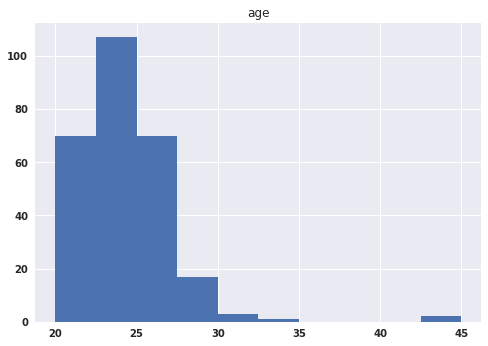

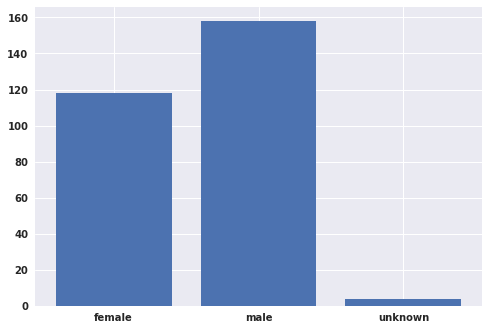

In [12]:
import os
if not os.path.exists('results/odi/'):
    os.makedirs('results/odi/')
    
from collections import Counter


def show_save_histogram(df, column_name):
    """ Makes and saves a histogram of a specific df column. """
    df.hist(column=column_name)
    plt.savefig("results/odi/" + column_name + ".png")



def make_bar_chart(df, column_name):
    """ Makes a bar chart given a data frame column. """
    
    freqs = Counter(df[column_name])
    xvals = range(len(freqs.values()))
    
    plt.figure()
    plt.bar(xvals, freqs.values())
    plt.xticks(xvals, freqs.keys())
    
    plt.savefig("results/odi/" + column_name + ".png")

show_save_histogram(df_new, "age")


make_bar_chart(df, "gender")


In [13]:
# Descriptives

# Age
mean_age = df_new.loc[:,"age"].mean()
print(f"mean age: {mean_age}")
std_age = df_new.loc[:,"age"].std()
print(f"standard deviation age: {std_age}")

# Neighbors
mean_neighbors = df_new.loc[:,"neighbors"].mean()
print(f"mean neighbors: {mean_neighbors}")
std_neighbors = df_new.loc[:,"neighbors"].std()
print(f"standard deviation neighbors: {std_neighbors}")

# Stress
mean_stress = df_new.loc[:,"stress"].mean()
print(f"mean stress: {mean_stress}")
std_stress = df_new.loc[:,"stress"].std()
print(f"standard deviation stress: {std_stress}")

# Random number
mean_random = df_new.loc[:,"random_number"].mean()
print(f"mean random: {mean_random}")
std_random = df_new.loc[:,"random_number"].std()
print(f"standard deviation random: {std_random}")

mean age: 24.122222222222224
standard deviation age: 2.7571917901252494
mean neighbors: 3.6496350364963503
standard deviation neighbors: 42.677097724610846
mean stress: 3.3714285714285714
standard deviation stress: 2.683663192556098
mean random: 2.1214300401233584e+35
standard deviation random: 3.4534378759965964e+36


# Correlations

In [14]:
clean_stand = []
for s in df_new['standed_up']:
    if s == 'no':
        clean_stand.append(0)
    elif s == 'yes':
        clean_stand.append(1)
    else:
        clean_stand.append(np.nan)
df_new['standed_up'] = clean_stand
print(df_new['standed_up'].unique())


[ 0. nan  1.]


In [15]:
c_1 = 0
c_0 = 0
for index, row in df_new.iterrows():
    if row['program'] == "CLS":
        if row['ml_course'] == 0:
            c_0 +=1
        elif row['ml_course'] == 1:
            c_1 +=1
print(f"1 = {c_1}")
print(f"0 = {c_0}")

1 = 20
0 = 18


In [16]:
times = []
for time in df_new['bedtime_yesterday']:
    if time == time:
        if time.hour == 19 or time.hour == 21 or time.hour == 22:
            times.append(time.hour)
        elif time.hour == 23 or time.hour == 11:
            times.append(23)
        elif time.hour == 0 or time.hour == 12:
            times.append(24)
        elif time.hour == 1 or time.hour == 13:
            times.append(25)
        elif time.hour == 2:
            times.append(26)
        elif time.hour == 15 or time.hour == 3:
            times.append(27)
        elif time.hour == 4 or time.hour == 16:
            times.append(28)
        elif time.hour == 5:
            times.append(29)
    else:
        times.append(np.nan)
df_new['bedtime_yesterday'] = times

print(df_new['bedtime_yesterday'].unique())


[22. 23. nan 24. 25. 26. 28. 27. 29. 21. 19.]


In [17]:
# cov3_df = pd.DataFrame()
# cov3_df['stress'] = df_new['stress']
# cov3_df['bedtime'] = [float(n) for n in df_new['bedtime_yesterday']]
# cov3_df.cov()
# # plt.plot(cov_df['stress'], cov_df['nr'])
# # display(cov2_df)


In [18]:
import scipy.stats as scs

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)

# ml_course & program > chi square
# df_col1, df_col2 = df_new['gender'], df_new['standed_up']

# result = [[sum((df_col1 == cat1) & (df_col2 == cat2)) for cat2 in categories(df_col2)] 
#           for cat1 in categories(df_col1)]

# chi2_stat, p_val, dof, ex = scs.chi2_contingency(result)
# print("===Chi2 Stat===")
# print(chi2_stat)
# print("\n")
# print("===Degrees of Freedom===")
# print(dof)
# print("\n")
# print("===P-Value===")
# print(p_val)
# print("\n")
# print("===Contingency Table===")
# print(ex)

In [19]:
display(df_new)

,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,neighbors,standed_up,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2,age,sun,food,followed_courses
0,CLS,0.0,NaN,1.0,1.0,female,fat,1998-08-05,0.0,0.0,0.0,4,227,22.0,Good weather,Sporting,21.0,1,0,0.25
1,QRM,0.0,0.0,1.0,0.0,male,unknown,1996-01-01,2.0,0.0,8.0,25,65,23.0,chill,coffee,24.0,0,0,-0.50
2,CLS,0.0,0.0,1.0,1.0,female,neither,1996-01-01,4.0,0.0,4.0,10,3,NaN,Waking up early and preparing for the day by p...,Using the early morning time to study,24.0,0,0,0.00
3,QRM,0.0,0.0,1.0,0.0,female,neither,1994-06-19,0.0,0.0,0.0,99,2,NaN,eating good food,spending time with friends,25.0,0,1,-0.50
4,OTHER,1.0,0.0,1.0,1.0,male,neither,1993-09-29,0.0,0.0,5.0,80,7,22.0,Sun is shining,Intimate contact with friends and family,26.0,1,0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,AI,1.0,1.0,1.0,0.0,male,fat,1993-09-17,2.0,0.0,6.0,5,6,NaN,no corona,no corona 2,26.0,0,0,0.50
276,CS,0.0,0.0,1.0,1.0,male,fat,1993-09-17,0.0,0.0,0.0,100,7,21.0,Netflix,Chill,26.0,0,0,0.00
277,AI,1.0,1.0,1.0,1.0,male,neither,1994-07-26,12.0,1.0,5.0,75,42,25.0,Finishing all tasks,Finding an extra package of ice cream,25.0,0,0,1.00
278,AI,0.0,0.0,1.0,0.0,female,neither,1998-04-03,1.0,0.0,6.0,2,69,24.0,Food,Orgasm,22.0,0,1,-0.50


### Explore correlations with gender

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


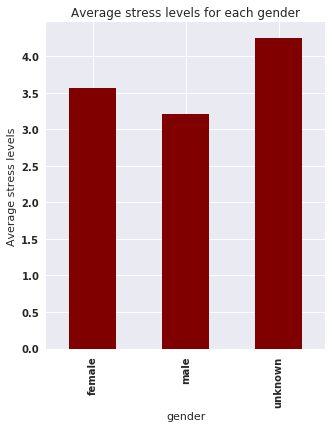

In [20]:
# Average stress for each gender
ax = plt.subplot()
ax.set_ylabel('Average stress levels')
ax.set_title('Average stress levels for each gender')
df_new.groupby('gender').mean()['stress'].plot(kind='bar', 
                                               figsize=(5, 6), 
                                               ax = ax,
                                               color="maroon");

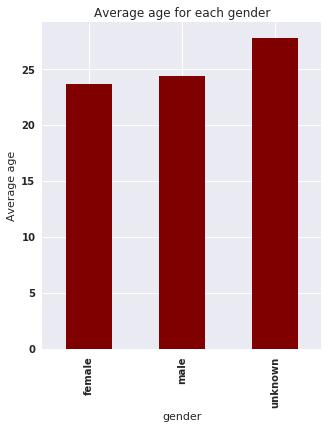

In [21]:
# Average age for each gender
ax = plt.subplot()
ax.set_ylabel('Average age')
ax.set_title('Average age for each gender')
df_new.groupby('gender').mean()['age'].plot(kind='bar', 
                                               figsize=(5, 6), 
                                               ax = ax,
                                               color="maroon");

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


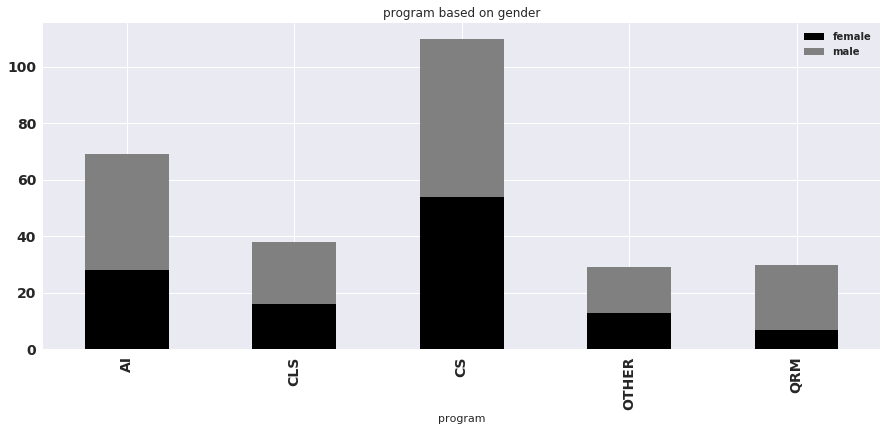

In [22]:
# Convert chocolate categories
try:
    df_new['gender'] = df_new['gender'].map( {'female': 0, 'male': 1, 'unknown': 2} ).astype(int)
    df_new['chocolate'] = df_new['chocolate'].map( {'fat': 0, 'neither': 1, 'I have no idea what you are talking about':2, 'slim':3, 'unknown': 4} ).astype(int)
except ValueError:
    print("already converted to int")
    
col_male, col_female = [], []
for index, row in df_new.iterrows():
    if row["gender"] == 1:
        col_male.append(1)
    else:
        col_male.append(0)
    
    if row["gender"] == 0:
        col_female.append(1)
    else:
        col_female.append(0)
    
try:
    df_new.insert(loc=0, column='male', value=pd.Series(col_male))
    df_new.insert(loc=0, column='female', value=pd.Series(col_female))   
except ValueError:
    print("Already added col")


plot = df_new.groupby('program').agg('sum')[['female', 'male']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(15, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="program based on gender");

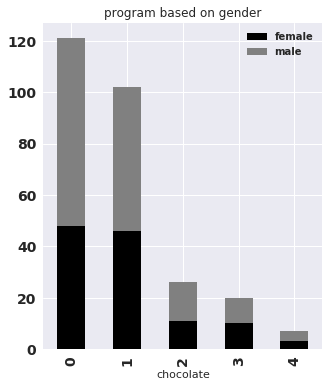

In [23]:
plot = df_new.groupby('chocolate').agg('sum')[['female', 'male']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(5, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="program based on gender");

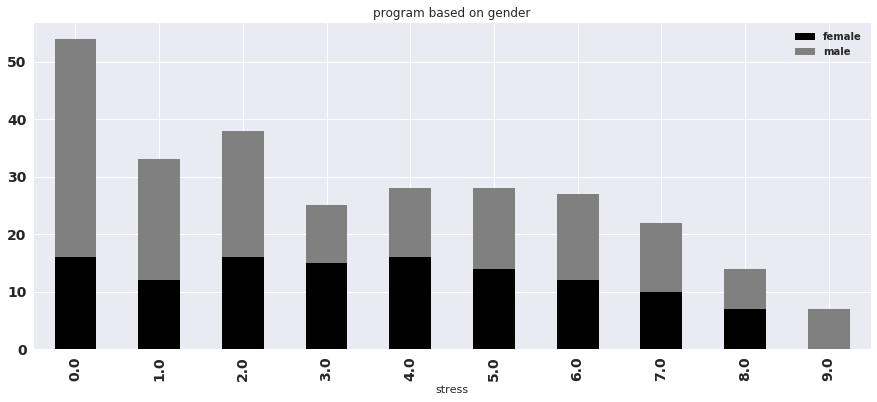

In [24]:
plot = df_new.groupby('stress').agg('sum')[['female', 'male']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(15, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="program based on gender");

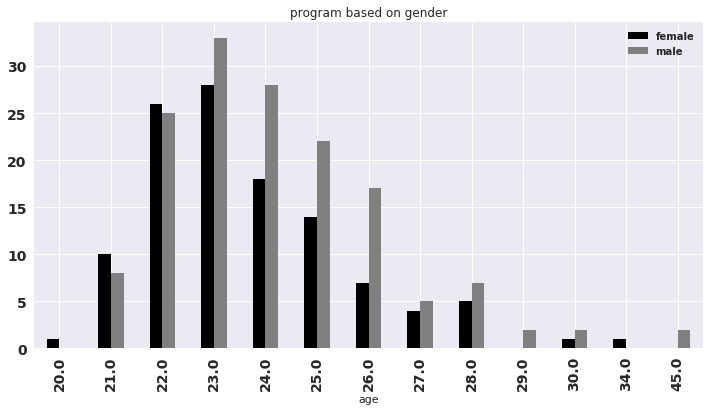

In [25]:
plot = df_new.groupby('age').agg('sum')[['female', 'male']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(12, 6),
                                                                    stacked=False, 
                                                                    color=['black', 'grey'],
                                                                    title="program based on gender");

In [26]:
df_new.groupby('gender')['age'].mean() # 0 = female, 1 = male, 2 = unknown



gender
0    23.669565
1    24.370861
2    27.750000
Name: age, dtype: float64

In [27]:
df_new.groupby('age').agg('sum')[['female', 'male']]

,female,male
age,,
20.0,1,0
21.0,10,8
22.0,26,25
23.0,28,33
24.0,18,28
25.0,14,22
26.0,7,17
27.0,4,5
28.0,5,7


In [28]:
display(df_new)

,female,male,program,ml_course,ir_course,stat_course,db_course,gender,chocolate,birthday,...,stress,local_dm_comp,random_number,bedtime_yesterday,happy1,happy2,age,sun,food,followed_courses
0,1,0,CLS,0.0,NaN,1.0,1.0,0,0,1998-08-05,...,0.0,4,227,22.0,Good weather,Sporting,21.0,1,0,0.25
1,0,1,QRM,0.0,0.0,1.0,0.0,1,4,1996-01-01,...,8.0,25,65,23.0,chill,coffee,24.0,0,0,-0.50
2,1,0,CLS,0.0,0.0,1.0,1.0,0,1,1996-01-01,...,4.0,10,3,NaN,Waking up early and preparing for the day by p...,Using the early morning time to study,24.0,0,0,0.00
3,1,0,QRM,0.0,0.0,1.0,0.0,0,1,1994-06-19,...,0.0,99,2,NaN,eating good food,spending time with friends,25.0,0,1,-0.50
4,0,1,OTHER,1.0,0.0,1.0,1.0,1,1,1993-09-29,...,5.0,80,7,22.0,Sun is shining,Intimate contact with friends and family,26.0,1,0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0,1,AI,1.0,1.0,1.0,0.0,1,0,1993-09-17,...,6.0,5,6,NaN,no corona,no corona 2,26.0,0,0,0.50
276,0,1,CS,0.0,0.0,1.0,1.0,1,0,1993-09-17,...,0.0,100,7,21.0,Netflix,Chill,26.0,0,0,0.00
277,0,1,AI,1.0,1.0,1.0,1.0,1,1,1994-07-26,...,5.0,75,42,25.0,Finishing all tasks,Finding an extra package of ice cream,25.0,0,0,1.00
278,1,0,AI,0.0,0.0,1.0,0.0,0,1,1998-04-03,...,6.0,2,69,24.0,Food,Orgasm,22.0,0,1,-0.50


### Regression

In [29]:
# train & return a classifier
def train_regression(frame):
    # independent variables: ml_course, ir_course, stat_course, db_course
    X = frame['followed_courses'].values.reshape(-1,1)
    
    # dependent variable: stress category 0-9
    Y = frame['stress'].values.reshape(-1,1)
    
    # fit a linear model
    lr = LinearRegression()
    lr.fit(X,Y)
    
    return lr
    
# use a given classifier and test its performance, return a performance measure
def test_regression(frame, classifier):
    X = frame['followed_courses'].values.reshape(-1,1)
    Y = frame['stress'].values.reshape(-1,1)
    Y_pred = classifier.predict(X)
    
    # visualize
    plt.scatter(X,Y)
    plt.plot(X,Y_pred,color='red')
    plt.show()
    
    # compute mean squared error
    mse = mean_squared_error(Y, Y_pred)

    return mse

# k-fold cross validation, takes as an argument a pandas dataframe
def kfold(df):

    # determine amount of folds
    k = 4

    # keep track of created datasets
    folds = []
        
    # substract k subsets
    for i in range(k):
        drop_indices = np.random.choice(df.index, int((1/k)*len(df)), replace=False)
        folds.append(df.drop(drop_indices))
        df.drop(drop_indices, inplace=True)

    # keep track of performances
    performances = []
    
    # for each subset (fold)
    for j in range(len(folds)):

        # take this fold as test set
        test_data = folds[j]

        # take remaining groups as training set
        train_dataframes = []
        
        for k in range(len(folds)):
            if k != j:
                train_dataframes.append(folds[k])
                
        train_data = pd.concat(train_dataframes)

        # train & test regression
#         solution = train_regression(train_data)
#         performances.append(test_regression(test_data, solution))
        
        # train & test 1R
        solution = train_weighted_1R(train_data)
        performances.append(test_weighted_1R(test_data, solution))
        
    print(performances)
    # compute overall performance
    return statistics.mean(performances)

# kfold(df_new)

In [30]:
def train_weighted_1R(frame):
    weights = {'CLS':{'T':0,'Y':0,'P':0}, 'AI':{'T':0,'Y':0,'P':0}, 'CS':{'T':0,'Y':0,'P':0},
               'QRM':{'T':0,'Y':0,'P':0}, 'OTHER':{'T':0,'Y':0,'P':0}}
    
    for index, row in frame.iterrows():
        weights[row['program']]['T'] += 1
        if row['ml_course'] == 1:
            weights[row['program']]['Y'] += 1
    
    for key, value in weights.items():
        if value['T'] != 0:
            value['P'] = value['Y']/value['T']
        
    return weights

def test_weighted_1R(frame,weights):
    predictions = []
    
    for index,row in frame.iterrows():
        p_value = weights[row['program']]['P']
        if random.uniform(0,1) < p_value:
            predictions.append(1)
        else:
            predictions.append(0)

    good_predictions = 0
    i = 0
    for index,row in frame.iterrows():
        if predictions[i] == row['ml_course']:
            good_predictions += 1
        i += 1
        
    print(f"performance = good predictions ({good_predictions}) / total({len(predictions)})")
    performance = good_predictions / len(predictions)
    
    # performance is percentage correctly predicted
    return performance

In [31]:
counter = 0
for index, row in df_new.iterrows():
    if row['ml_course'] == 0:
        counter += 1
print(counter)


99


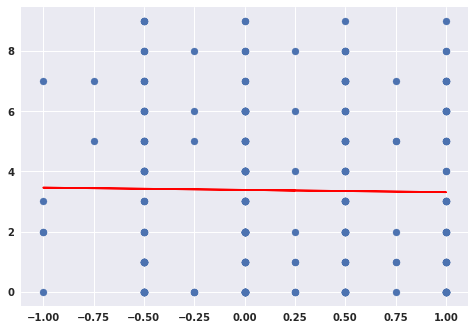

In [32]:
def regression(frame):
    
    # independent variables: ml_course, ir_course, stat_course, db_course
    X = frame['followed_courses'].values.reshape(-1,1)
    
    # dependent variable: stress category 0-9
    Y = frame['stress'].values.reshape(-1,1)
    
    # fit a linear model
    lr = LinearRegression()
    lr.fit(X,Y)
    
    Y_pred = lr.predict(X)
    
    # visualize
    plt.scatter(X,Y)
    plt.plot(X,Y_pred,color='red')
    plt.show()

regression(df_new)
#print(df_new['stress'].unique())
#print(df_new['followed_courses'].unique())

## Random forest classifier

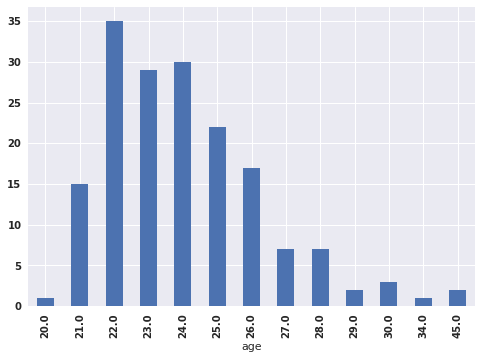

In [33]:
alldata = df_new.groupby('age').agg('sum')["ml_course"]
alldata
alldata.plot(kind="bar")

In [34]:
df_new['bedtime_yesterday'] = df_new['bedtime_yesterday'].fillna(1)
df_new['age'] = df_new['age'].fillna(2)
df_new['ir_course'] = df_new['ir_course'].fillna(1)
df_new['stat_course'] = df_new['stat_course'].fillna(1)
df_new['ml_course'] = df_new['ml_course'].fillna(1)


In [35]:
df_new['program'] = df_new['program'].map( {'CLS': 0, 'AI': 1, 'CS': 2, 'QRM':3, 'OTHER':4} ).astype(int)


In [36]:

# Categories for bedtime
df_new.loc[ df_new['bedtime_yesterday'] <= 22.0, 'bedtime_yesterday'] = 0
df_new.loc[(df_new['bedtime_yesterday'] > 22) & (df_new['bedtime_yesterday'] <= 25), 'bedtime_yesterday'] = 1
df_new.loc[ df_new['bedtime_yesterday'] > 25, 'bedtime_yesterday'] = 2

# Categories for age
df_new.loc[ df_new['age'] <= 22, 'age'] = 0
df_new.loc[(df_new['age'] > 22) & (df_new['age'] <= 25), 'age'] = 1
df_new.loc[(df_new['age'] > 22) & (df_new['age'] <= 24), 'age'] = 2
df_new.loc[(df_new['age'] > 24) & (df_new['age'] <= 26), 'age'] = 3
df_new.loc[ df_new['age'] > 26, 'age'] = 4


# Drop categories from dataframe
df_new.drop(columns=['chocolate', 'birthday', 'local_dm_comp', 'random_number', 'happy1', 'happy2', 'followed_courses', 'standed_up', 'neighbors', 'db_course'], axis=1, inplace=True)



In [37]:
display(df_new)

,female,male,program,ml_course,ir_course,stat_course,gender,stress,bedtime_yesterday,age,sun,food
0,1,0,0,0.0,1.0,1.0,0,0.0,0.0,0.0,1,0
1,0,1,3,0.0,0.0,1.0,1,8.0,1.0,1.0,0,0
2,1,0,0,0.0,0.0,1.0,0,4.0,0.0,1.0,0,0
3,1,0,3,0.0,0.0,1.0,0,0.0,0.0,1.0,0,1
4,0,1,4,1.0,0.0,1.0,1,5.0,0.0,3.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
275,0,1,1,1.0,1.0,1.0,1,6.0,0.0,3.0,0,0
276,0,1,2,0.0,0.0,1.0,1,0.0,0.0,3.0,0,0
277,0,1,1,1.0,1.0,1.0,1,5.0,1.0,1.0,0,0
278,1,0,1,0.0,0.0,1.0,0,6.0,1.0,0.0,0,1


In [139]:
# Drop categories from dataframe
df_stress = df_new[["stress", 'program', 'ml_course', 'ir_course', 'stat_course']]
X_train, X_test = train_test_split(df_stress, test_size=0.2)
Y_train = X_train["program"]
Y_test = X_test["program"]
X_train = X_train.drop("program", axis=1).copy()
X_test = X_test.drop("program", axis=1).copy()


X_train.shape, Y_train.shape, X_test.shape

((224, 4), (224,), (56, 4))

In [39]:
X_train

,female,male,ml_course,ir_course,stat_course,gender,stress,bedtime_yesterday,age,sun,food
272,1,0,0.0,0.0,1.0,0,0.0,0.0,4.0,0,0
46,1,0,0.0,0.0,1.0,0,2.0,1.0,1.0,1,0
211,1,0,0.0,1.0,1.0,0,3.0,0.0,1.0,1,0
75,1,0,1.0,0.0,1.0,0,0.0,0.0,0.0,1,1
178,0,1,0.0,1.0,1.0,1,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8,1,0,1.0,0.0,1.0,0,0.0,1.0,0.0,0,0
94,1,0,1.0,0.0,0.0,0,8.0,0.0,1.0,0,0
144,0,1,1.0,1.0,0.0,1,0.0,0.0,0.0,1,0
120,0,1,0.0,1.0,1.0,1,0.0,1.0,1.0,0,0


In [140]:
# Random forest
random_forest = RandomForestClassifier(n_estimators=90, max_depth=5, random_state=1)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)


acc_random_forest = random_forest.score(X_train, Y_train) * 100
print("Accuracy of the random forest: ", acc_random_forest)
    
# print(Y_pred, Y_test)

Accuracy of the random forest:  54.46428571428571


In [141]:
acc_random_forest = random_forest.score(X_test, Y_test) * 100
print("Accuracy = ", acc_random_forest)

37.5
Correct answers:  21 = 38 %


In [ ]:
# Check number of correct answers
count = 0
try:
    Y_test = Y_test.reset_index()
except ValueError:
    print("Already converted")
for index in range(len(Y_test)):
    if Y_pred[index] == Y_test["program"][index]:
        count += 1
print("Correct answers: ", count, "=", round((count / len(Y_pred)) * 100), "%")